### Part 3 - Artificial Curiosity Loop

implementing Artficial Curiosity Loop using Actor-Critic approach and bayesian learning

In [1]:
import pandas as pd
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm, trange
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import beta 
from sklearn.utils import shuffle

# PreProcess
### Create dataset
Remain only with the following features:  
```action_type, shot_zone_area, position```

In [2]:
data = pd.read_csv('..\\dataset_ver1.csv')
data = shuffle(data)
dataset = data[[u'action_type', 
                 u'shot_made_flag',u'shot_zone_area', u'position']]

### Filter the 'no shot' 

In [3]:
dataset = dataset[dataset.action_type != 'No Shot']

### convert ```action_type``` feature

In [4]:
dataset['action_type'] = dataset.action_type.apply(lambda x: x.split(' ')[-2])

### Unite Positions

In [5]:
def transpos(position):
    '''transfers position to numeric value (10-50)'''
    dic = {'Guard':'G', 'Center':'C', 'Forward':'F', 'Guard-Forward':'G', 'Center-Forward':'C',
       'Forward-Center':'F', 'Forward-Guard':'F'}
    return dic[position]
dataset['position_sign'] = dataset.position.apply(transpos)
dataset.drop('position', axis=1,inplace=True)

In [6]:
dataset.groupby('position_sign', as_index=False).size()

position_sign
C     58514
F    161923
G    189348
dtype: int64

In [7]:
dataset.groupby('action_type', as_index=False).size()

action_type
Bank          7260
Dunk         19775
Fadeaway      2840
Hook         15348
Jump        261556
Layup        98816
Tip           4190
dtype: int64

In [8]:
dataset.groupby('shot_zone_area', as_index=False).size()

shot_zone_area
Back Court(BC)              976
Center(C)                224970
Left Side Center(LC)      47292
Left Side(L)              45767
Right Side Center(RC)     47472
Right Side(R)             43308
dtype: int64

In [9]:
dataset.rename(columns={'shot_made_flag' : 'label'}, inplace=True)
dataset.head()

,action_type,label,shot_zone_area,position_sign
147700,Layup,1,Center(C),G
277379,Jump,0,Right Side Center(RC),G
8685,Jump,1,Right Side Center(RC),G
162420,Layup,1,Center(C),F
119146,Dunk,1,Center(C),F


### Filter the rare shots (by the combinations of the features)

In [10]:
d = dataset.groupby(by=['action_type', 'shot_zone_area','position_sign'] ,as_index=False)['label'].size().reset_index()
d.columns = list(d.columns[:-1]) + ['shots_count']
d= d[d.shots_count <=10]
d['concat_it'] = d.apply(lambda x: x.action_type +'_'+ x.shot_zone_area +'_' + x.position_sign, axis=1)

In [11]:
good_set = set(d.concat_it.unique())
msk = dataset.apply(lambda x: x.action_type +'_'+ x.shot_zone_area +'_' + x.position_sign in good_set, axis=1)
dataset = dataset[~msk]
dataset.groupby(by=['action_type', 'shot_zone_area','position_sign'] ,as_index=False)['label'].mean().head()

,action_type,shot_zone_area,position_sign,label
0,Bank,Center(C),C,0.694309
1,Bank,Center(C),F,0.641696
2,Bank,Center(C),G,0.648091
3,Bank,Left Side Center(LC),F,0.576923
4,Bank,Left Side Center(LC),G,0.570175


And now the possible shot probabilities are within  

In [12]:
print 'min ',dataset.groupby(by=['action_type', 'shot_zone_area','position_sign'] ,as_index=False)['label'].mean()['label'].min()
print 'max ',dataset.groupby(by=['action_type', 'shot_zone_area','position_sign'] ,as_index=False)['label'].mean()['label'].max()

min  0.0204081632653
max  0.914912990692


Global Prior (the chance to score):

In [13]:
PriorY = dataset.label.mean()
PriorY

0.4516359713564675

### Calculate Posterior and InformationGain

In [14]:
def new_actions(test):
    ''' samples 5 possible actions from the given test set'''
    C = test[test.position_sign == 'C'].sample(1)
    G = test[test.position_sign == 'G'].sample(2)
    F = test[test.position_sign == 'F'].sample(2)
    return pd.concat([C,G,F])

In [15]:
def softmax(lista):
    '''returns the softmax numpy array of lista'''
    e = np.exp(np.array(lista))
    return e / np.sum(e)

In [16]:
def weighted_avg(lista, q):
    '''returns the weighted probabilities'''
    lista = np.power(lista,q)
    return lista / sum(lista)

In [17]:
def IG(a,b,label):
    ''' calculates the information gain, based on the result of the shot'''
    prior = beta(a,b)
    if label:
        shot_post = beta(a+1,b)
        return prior.entropy() - shot_post.entropy()
    else:
        miss_post = beta(a,b+1)
        return prior.entropy() - miss_post.entropy()

In [18]:
def EIG(tup):
    '''returns the expected IG'''
    prior = beta(tup[0],tup[1])
    shot_IG = IG(tup[0],tup[1],1)
    miss_IG = IG(tup[0],tup[1],0)
    try: exp = prior.expect()
    except: exp = tup[0]*1.0/(tup[0]+tup[1])
    return exp*shot_IG + (1-exp)*miss_IG # expectation calculation

In [19]:
def get_probabilities(df_row, ModelEvidence):
    ''' returns a tuple of count(X|Y=1),count(X|Y=0)'''
    return ModelEvidence.get((df_row['action_type'], df_row['shot_zone_area'], df_row['position_sign']),(1,1))
  

In [20]:
def predict(df_row, ModelEvidence):
    tup = get_probabilities(df_row, ModelEvidence)
    return float(tup[0])/(tup[0]+tup[1])

In [21]:
def critic(ModelEvidence, new_actions, lamda):
    '''gets the bayesian learners, 5 actions and returns the EIG for each action,  lamda is the weight of curiosity'''
    func_value,probs,eigs = [],[],[]
    for i in range(len(new_actions)):
        p =predict(new_actions.iloc[i], ModelEvidence)
        eig = EIG(get_probabilities(new_actions.iloc[i], ModelEvidence))
        probs.append(p)
        eigs.append(eig)
        func_value.append(100*lamda*eig + (1-lamda)*p)    
        
    return func_value,probs,eigs

In [22]:
def actor(func_value, new_actions):
    '''gets the predicted values for each new_actions and outputs the chosen one'''
    func_value = weighted_avg(func_value,q=3)
    result =np.random.choice(range(len(new_actions)), 1, p=func_value)
    maxx = np.argmax(func_value)
    return result[0], maxx==result[0]

In [23]:
def iteration(actions, ModelEvidence, lamda):
    '''one iteration in the Q loop, lamda is the weight of curiosity
        returns updated model, chosen action, score, probability, error(missing), eig and ig'''
    scores, probs,eigs = critic(ModelEvidence, actions, lamda)
    ind, same = actor(scores, actions) # chosen shoot, and its index
    choice = actions.iloc[ind]
    score,p,eig=scores[ind], probs[ind], eigs[ind]
    err = (p-choice['label'])**2
    tup = get_probabilities(actions.iloc[ind],ModelEvidence)
    ig = IG(tup[0],tup[1],choice['label'])
    
    key = (choice['action_type'], choice['shot_zone_area'], choice['position_sign'])
    ModelEvidence = update_evidence(key, choice['label'].max(), ModelEvidence)
    
    return ModelEvidence, choice, score,p, err, eig, ig, int(same), ind

## Curiosity Loop:
![](loop.png)

[read more in the presentation](../Pres.pdf)

## Simulation - "New-born" AI agent takes shots from diffent positions and learns the success of each shot, while trying to score as much as possible

## A Game

In [24]:
def game(players_evidence, test,lamda, rounds = 100):
    ''' a game played by a single player'''
    i,points = 0, [[],[],[]]
    same = [0,0,0]
#     for po in range(len(lamda_list)): same[po] =0
    Score,Prob,Err,ExpIG,RealIG,Indexes,choices = [[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]] # stats documentation
#     same = []
    for i in trange(rounds):
        if len(test) == 0:
            break
        actions = new_actions(test)
        for pl in range(len(players_evidence)):
            players_evidence[pl], choice, score,p, err, eig, ig, sm, ind= iteration(actions, players_evidence[pl], lamda[pl])
            same[pl] += int(sm)
            points[pl].append(choice['label'])
            Score[pl].append(score)
            ExpIG[pl].append(eig)
            RealIG[pl].append(ig)
            Err[pl].append(err)
            Prob[pl].append(p)
            Indexes[pl].append(ind)
            choices[pl].append(choice)
        test = test.drop(actions.index) # remove the possible actions... (we used it)
    return players_evidence, test, points, Score, ExpIG, RealIG, Prob, Err, same, Indexes,choices

# Bayesian Inference

In [25]:
def Posterior(sample,cols,ModelEvidence):
    ''' calculated Naive bayes posterior based on Prior and evidence'''
    total = ModelEvidence['all'] # all train set
    Prior = total[0]*1.0/(total[0]+total[1])
    Post = Prior # P(Y=1) Precalc
    for ev in cols:
        Post = Post*ModelEvidence[ev][sample[ev]][0]/total[0] # P(X|Y)
        Post = Post/(sum(ModelEvidence[ev][sample[ev]])/sum(total)) # P(X)
    return Post

In [26]:
def update_evidence(key, label, ModelEvidence):
    ''' update the ModelEvidence with the input'''
    if key in ModelEvidence:
        ModelEvidence[key] = (ModelEvidence[key][0]+label, ModelEvidence[key][1]+(1-label))
    else:
        ModelEvidence[key] = (1 +label, 1+(1-label))
    return ModelEvidence

### Build the ModelEvidence on the train set
## 3 Players

### Set the initial dataset

In [27]:
TrainSize= 0 # prior knowledge
TestSize = 20000
ValSize = 20000
train=dataset[:TrainSize]
test=dataset[TrainSize:TrainSize+TestSize]
validation = dataset[TrainSize+TestSize:TrainSize+TestSize+ValSize]

In [28]:
# initial knowledge
ModelEvidence = {}
for ind, value in train.iterrows():
    key = (value['action_type'], value['shot_zone_area'],value['position_sign'])
    label = value['label']
    ModelEvidence = update_evidence(key, label, ModelEvidence)

In [29]:
nameslist = ['Greedy','Balanced','Curious']

In [30]:
# teach all players initial knowledge (default=0)
players_evidence =[]
lamda_list=[0,0.1,1]
rounds = 2500
for p in range(len(lamda_list)):
    players_evidence.append(ModelEvidence.copy())

In [31]:
# Play a Game
print 'began at' , datetime.now()
players_evidence, test, points, Score, ExpIG,  RealIG, Prob, Err, same, indexes, choices = game(players_evidence, test,lamda = lamda_list, rounds=rounds)
print 'ended at ', datetime.now()

began at 2017-01-20 19:40:51.798000


100%|██████████████████████████████████████| 2500/2500 [07:08<00:00,  5.30it/s]


ended at  2017-01-20 19:48:00.492000


###  Information Gain: Expectation - Real

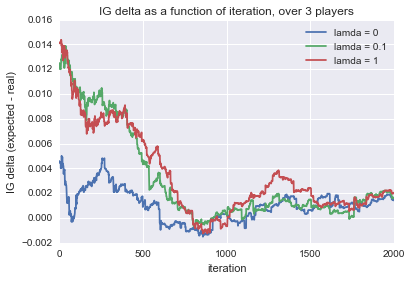

In [32]:
IG_delta_plot = [[],[],[]]
ls =[[],[],[]]
players = 3
k=500
for pl in range(players):
    for i in range(len(ExpIG[pl])-k):
        ls[pl] = [x1 - x2 for (x1, x2) in zip(ExpIG[pl], RealIG[pl])]
        IG_delta_plot[pl].append(sum(ls[pl][i:i+k])/k)
        
        
legend_tl = []
for pl in range(len(IG_delta_plot)):
    plt.plot(range(len(IG_delta_plot[pl])), IG_delta_plot[pl])
    legend_tl.append('lamda = '+str(lamda_list[pl]))
plt.legend(legend_tl)
plt.ylabel('IG delta (expected - real)')
plt.xlabel('iteration')
plt.title('IG delta as a function of iteration, over 3 players')
plt.show()

### Expected IG on different $\lambda$

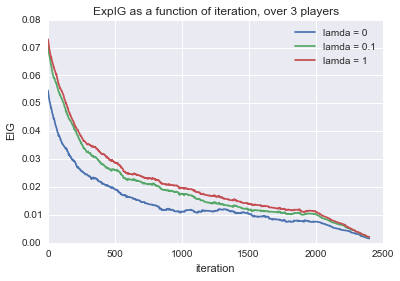

In [33]:
ExpIG_plot = [[],[],[]]
players = 3
k=500

for pl in range(players):
    for i in range(2400):
        ExpIG_plot[pl].append(sum(ExpIG[pl][i:i+k])/k)
        
legend_tl = []
for pl in range(len(ExpIG_plot)):
    plt.plot(range(len(ExpIG_plot[pl])), ExpIG_plot[pl])
    legend_tl.append('lamda = '+str(lamda_list[pl]))
plt.legend(legend_tl)
plt.ylabel('EIG')
plt.xlabel('iteration')
plt.title('ExpIG as a function of iteration, over 3 players')
plt.show()

## Points

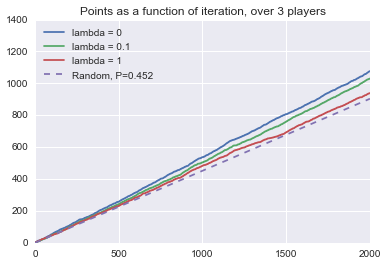

In [34]:
points_plot = [[],[],[]]
for pl in range(len(points)):
    points_plot[pl] = np.cumsum(np.array(points[pl]))
legend_tl = []

for pl in range(len(points_plot)):
    plt.plot(range(rounds), points_plot[pl])
    legend_tl.append('lambda = '+str(lamda_list[pl]))
plt.plot(range(rounds), map(lambda x: x*PriorY,range(rounds)), '--')
legend_tl.append('Random, P='+str(round(PriorY,3)))
plt.legend(legend_tl,loc=2)
plt.xlim([0,2000])
plt.ylim([0,1400])
plt.title('Points as a function of iteration, over 3 players')
plt.show()

# Error Plot

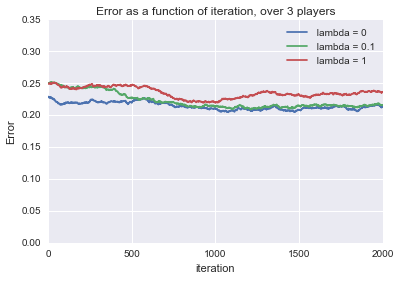

In [44]:
Err_plot = [[],[],[]]
players = 3
k=250
for pl in range(players): #smoothing
    for i in range(k,len(Err[pl])-k):
        Err_plot[pl].append(sum(Err[pl][i-k:i+k])/(2*k))
        
legend_tl = []
for pl in range(len(Err_plot)):
    plt.plot(range(len(Err_plot[pl])), Err_plot[pl])
    legend_tl.append(' lambda = '+str(lamda_list[pl]))
plt.legend(legend_tl, loc=1)
plt.ylabel('Error')
plt.xlabel('iteration')
plt.ylim([0,0.35])
plt.title('Error as a function of iteration, over 3 players')
plt.show()

# Probability Plot

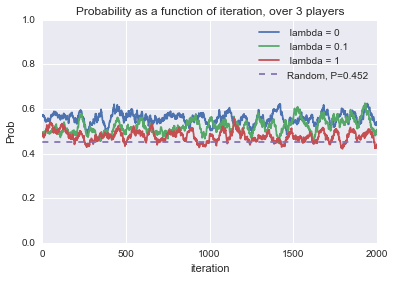

In [80]:
Prob_plot = [[],[],[]]
players = 3
k=20
for pl in range(players): #smoothing
    for i in range(k,2020):
        Prob_plot[pl].append(sum(Prob[pl][i-k:i+k])/(2*k))
        
legend_tl = []
for pl in range(len(Prob_plot)):
    plt.plot(range(len(Prob_plot[pl])), Prob_plot[pl])
    legend_tl.append(' lambda = '+str(lamda_list[pl]))

plt.plot(range(2000), map(lambda x: PriorY,range(2000)), '--')
legend_tl.append('Random, P='+str(round(PriorY,3)))
plt.legend(legend_tl, loc=1)
plt.ylabel('Prob')
plt.xlabel('iteration')
plt.ylim([0,1])
plt.title('Probability as a function of iteration, over 3 players')
plt.show()

## Plot Roc (after 2000 iterations)

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve
#plot ROC
def plot_ROC(Players,data,legend,title,scale='linear'):
    AUC = []
    fig2  = plt.figure()
    for Pl in Players:
        y_true ,y_scores = data.label,  data.apply(lambda x: predict(x,Pl), axis= 1)
        fpr, tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
        AUC.append(roc_auc_score(y_true, y_scores))
        plt.xlim([0.02,1.01])
        plt.ylim([-0.01,1.02])
        ax =plt.plot(fpr, tpr)
    leg = zip(legend,AUC)
    plt.yscale(scale)
    plt.xscale(scale)
    plt.title('ROC on '+title)
    l = plt.legend(map(lambda x: str(x[0])+' AUC:'+str(round(x[1],4)),leg), loc = 4)
    plt.show

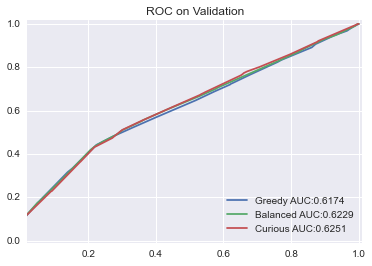

In [38]:
plot_ROC(players_evidence,validation,['Greedy','Balanced','Curious'],'Validation')